In [1]:
import pandas as pd
import torch
# import matplotlib.pyplot as plt
# import seaborn as sns
# import ast
import re
import sys

import pydicom as dicom
import pylibjpeg

effdet_path = "../third/effdet"
sys.path.append(effdet_path)


timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import matplotlib.pyplot as plt
# from matplotlib import patches
# import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf

# effunet_path = "../input/effdet-models/efficientunet-pytorch-0.0.6"
# sys.path.append(effunet_path)

# from effdet import create_model

import glob
# import sklearn
import math
import random
import numpy as np

from PIL import Image

# import cv2
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as T
import torchvision.transforms.functional as TF
# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
# from sklearn import metrics, model_selection, preprocessing

# from sklearn.model_selection import GroupKFold


# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_axial_images_jpeg95')

In [3]:
meta_df = pd.read_csv(os.path.join(DATA_DIR, 'meta_train_3d.csv')).set_index('UID')
print(len(meta_df))
meta_df.head()

2012


,z_spacing,pixel_spacing,aspect,is_flip
UID,,,,
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0
1.2.826.0.1.3680043.10005,0.625,0.298828,2.091504,0
1.2.826.0.1.3680043.10014,0.800,0.234000,3.418803,0
1.2.826.0.1.3680043.10016,0.313,0.275391,1.136566,0
1.2.826.0.1.3680043.10032,0.625,0.320313,1.951216,0


In [4]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train_df_with_slices.csv')).set_index('UID')
train_df = train_df.loc[meta_df.index.unique()]

print(len(train_df))
train_df.head()

2012


,patient_overall,C1,C2,C3,C4,C5,C6,C7,num_slices
UID,,,,,,,,,
1.2.826.0.1.3680043.10001,0,0,0,0,0,0,0,0,268
1.2.826.0.1.3680043.10005,0,0,0,0,0,0,0,0,259
1.2.826.0.1.3680043.10014,0,0,0,0,0,0,0,0,258
1.2.826.0.1.3680043.10016,1,0,1,0,0,0,0,0,645
1.2.826.0.1.3680043.10032,0,0,0,0,0,0,0,0,321


In [5]:
train_df = pd.concat((meta_df, train_df), axis=1)
train_df.head()

,z_spacing,pixel_spacing,aspect,is_flip,patient_overall,C1,C2,C3,C4,C5,C6,C7,num_slices
UID,,,,,,,,,,,,,
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,0,0,0,268
1.2.826.0.1.3680043.10005,0.625,0.298828,2.091504,0,0,0,0,0,0,0,0,0,259
1.2.826.0.1.3680043.10014,0.800,0.234000,3.418803,0,0,0,0,0,0,0,0,0,258
1.2.826.0.1.3680043.10016,0.313,0.275391,1.136566,0,1,0,1,0,0,0,0,0,645
1.2.826.0.1.3680043.10032,0.625,0.320313,1.951216,0,0,0,0,0,0,0,0,0,321


In [6]:
df = pd.DataFrame()

for i in tqdm(range(len(train_df))):
    s = train_df.iloc[i]
    new_df = train_df.loc[[s.name] * int(s.num_slices)]
    new_df['axial_index'] = np.arange(s.num_slices)
    
    df = pd.concat((df, new_df), axis=0)
    
print(len(df))
df.head()

100%|██████████| 2012/2012 [00:34<00:00, 58.25it/s]

708779


,z_spacing,pixel_spacing,aspect,is_flip,patient_overall,C1,C2,C3,C4,C5,C6,C7,num_slices,axial_index
UID,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,0,0,0,268,0.0
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,0,0,0,268,1.0
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,0,0,0,268,2.0
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,0,0,0,268,3.0
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,0,0,0,268,4.0


In [7]:
# df.to_csv(os.path.join(DATA_DIR, 'train_axial_infer_data.csv'))

z_spacing            0.625000
pixel_spacing        0.253906
aspect               2.461541
is_flip              0.000000
patient_overall      1.000000
C1                   0.000000
C2                   0.000000
C3                   0.000000
C4                   1.000000
C5                   0.000000
C6                   0.000000
C7                   0.000000
num_slices         272.000000
axial_index        140.000000
Name: 1.2.826.0.1.3680043.10051, dtype: float64
torch.Size([3, 512, 512]) tensor(-1.) tensor(0.8510)
0.253906


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


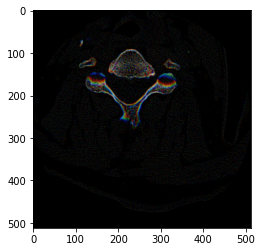

In [8]:
class ImageDataSet(torch.utils.data.Dataset):    
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms
        
        self.len = len(self.df)
        
    def __getitem__(self, i):
        
        s = self.df.iloc[i]

        rpath = os.path.join(self.path, s.name, f'{int(s.axial_index-1)}.jpeg')
        gpath = os.path.join(self.path, s.name, f'{int(s.axial_index)}.jpeg')
        bpath = os.path.join(self.path, s.name, f'{int(s.axial_index+1)}.jpeg')

        g = Image.open(gpath)
        r = Image.open(rpath) if os.path.exists(rpath) else g
        b = Image.open(bpath) if os.path.exists(bpath) else g

        img = Image.merge('RGB', (r, g, b))

        if self.transforms is not None:
            img = self.transforms(img)
        
        
        return img, s.pixel_spacing      
    
    def __len__(self):
        return self.len
    
class DataTransform(nn.Module):
    def __init__(self, image_size=512):
        super().__init__()

        self.image_size = image_size

        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize(0.5, 0.5),
        ])


    def forward(self, x):
        x = self.transform(x)

        return x

tf = DataTransform()
ds = ImageDataSet(df, IMAGES_DIR, tf)
index = 2111
print(df.iloc[index])
img, ps = ds[index]
print(img.shape, img.min(), img.max())
print(ps)

plt.imshow(img.permute(1, 2, 0))

In [9]:
segmentation_checkpoint=os.path.join(DATA_DIR, 'checkpoint',"axial_segmentation_effseg_132508-epoch-100.pth")
axial_det_checkpoint=os.path.join(DATA_DIR, 'checkpoint',"axial_detection_effdet_134352-epoch-52.pth")

In [10]:
from efficientunet import *
def get_axial_segmentation_model(checkpoint):
    model = get_efficientunet_b5(out_channels=2, concat_input=True, pretrained=False)
    
    state = torch.load(checkpoint, map_location=torch.device(device))
    model.load_state_dict(state["model"])
    model.eval()
    return model.to(device)
    
seg_model = get_axial_segmentation_model(segmentation_checkpoint)

In [11]:
from effdet import create_model

def get_axial_detection_model(checkpoint, image_size=512):
    model = create_model('efficientdetv2_ds' , bench_task='predict' , num_classes=1 , image_size=(image_size, image_size), pretrained=False, max_det_per_image=1)

    state = torch.load(checkpoint, map_location=torch.device(device))
    model.load_state_dict(state["model"])
    
    model = model.eval()
    return model.to(device)

det_model = get_axial_detection_model(axial_det_checkpoint)

In [12]:
def get_axial_boundary_from_segmentation(seg, pixel_spacing, throw=100, tol=0.2, max_mm=100):
    """
    seg : H x W
    """
    image_size = seg.shape[0]
    min_size = min(image_size, max_mm / pixel_spacing)
    
    rows, columns = seg.nonzero(as_tuple=True)
    rows.sort()
    columns.sort()
    
    throw = min(len(rows) // 2, throw)
    
    if(len(rows)) == 0:
        return torch.tensor([0, 0, image_size, image_size]).to(device)
    
    xmin, xmax = columns[throw], columns[-throw]
    ymin, ymax = rows[throw], rows[-throw]
    
    w = (xmax - xmin) * (1 + tol)
    h = (ymax - ymax) * (1 + tol)
    new_size = max(w, h, min_size)
    new_size = min(image_size, new_size)
    
    xcenter, ycenter = (xmax + xmin) / 2, (ymax + ymin) / 2
    
    xmin = torch.min(torch.tensor(image_size - new_size), xcenter - new_size / 2)
    xmin = xmin.clip(min=0)
    
    ymin = torch.min(torch.tensor(image_size - new_size), ycenter - new_size / 2)
    ymin = ymin.clip(min=0)
    
    return torch.stack([xmin, ymin, xmin + new_size, ymin + new_size])


def predict_seg(x, model, img_size=256):
    """
    return: N x 1 x H x W
    """
    x = TF.resize(x, (img_size, img_size))
    logits = model(x)

    classification_score, mse_score = logits.sigmoid().chunk(2, dim=1)
    classification_pred = classification_score.gt(0.5).float()
    pred = (classification_pred * mse_score)
    
    return pred


def get_axial_boundary(segs, pixel_spacings, seg_img_size=256):
    """
    결과는 512 x 512 단위로
    :param segs:
    :param pixel_spacings:
    :param seg_img_size:
    :return: N x 4
    """
    boundary_list = []
    for i in range(segs.shape[0]):
        seg = segs[i, 0, :, :]

        boundary = get_axial_boundary_from_segmentation(seg, pixel_spacings[i], throw=int(100 / 512 * seg_img_size), tol=0.2, max_mm=100 / 512 * seg_img_size)
        boundary_list.append(boundary)
    boundary_list = torch.stack(boundary_list, dim=0) * (512. / seg_img_size)
    return boundary_list

def predict_det(x, model):
    
    bboxes = model(x) # N x 1 x 6
    
    return bboxes[:, 0, :]
    
    
def crop_resize_images(imgs_tensor, boundary_list, img_size=512):
    croped_list = []
    for i in range(imgs_tensor.shape[0]):
        xmin, ymin, xmax, ymax = boundary_list[i, :]
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        # print(xmin, ymin, xmax, ymax)
        croped = TF.crop(imgs_tensor[i, :, :, :], top=ymin, left=xmin, height=ymax-ymin, width=xmax-xmin)
        croped = TF.resize(croped, (img_size, img_size))
        croped_list.append(croped)
        
    return torch.stack(croped_list, 0)

def get_original_bbox(bbox, boundary):
    scale = 512. / (boundary[:, [2]] - boundary[:, [0]])
    
    org_bbox = bbox / scale
    org_bbox[:, 0] += boundary[:, 0]
    org_bbox[:, 1] += boundary[:, 1]
    org_bbox[:, 2] += boundary[:, 0]
    org_bbox[:, 3] += boundary[:, 1]
    
    return org_bbox

def get_bbox_class(seg, bbox, img_size=256.):
    """
    label 은 0.125 의 단위로,
    seg: H x W
    bbox: [xmin, ymin, xmax, ymax]
    """
    xmin, ymin, xmax, ymax = bbox.int()
    bbox_seg = seg[ymin:ymax, xmin:xmax]

    # bbox 가 차지하는 면적
    bbox_area = (xmax - xmin) * (ymax - ymin)

    active_seg = bbox_seg[bbox_seg > 0]

    # seg 가 차지하는 면적
    active_area = active_seg.count_nonzero()
    # print(area)

    # TODO: 옛날 seg 는 round 해줘야 덴다
    clear_seg = torch.round(active_seg / 0.125)
    bbox_class = torch.mean(clear_seg)

    return bbox_class.round(), bbox_class, bbox_area / (img_size * img_size), active_area / bbox_area

def get_bbox_class_list(seg_list, seg_bboxes):
    class_index_list = []
    class_value_list = []
    bbox_area_list = []
    bbox_seg_area_list = []

    for i in range(seg_list.shape[0]):
        class_index, class_value, bbox_area, bbox_seg_area = get_bbox_class(seg_list[i, :, :], seg_bboxes[i, :])

        class_index_list.append(class_index)
        class_value_list.append(class_value)
        bbox_area_list.append(bbox_area)
        bbox_seg_area_list.append(bbox_seg_area)

    return torch.stack(class_index_list),torch.stack(class_value_list),torch.stack(bbox_area_list),torch.stack(bbox_seg_area_list),

def get_class_score(scores, class_list, eps=1e-2):
    result = scores.new_zeros((scores.shape[0], 8)) + eps
    class_list = torch.nan_to_num(class_list).long()
    result[torch.arange(scores.shape[0]), class_list] = scores

    return result

In [13]:
batch_size = 32
ds = ImageDataSet(df, IMAGES_DIR, tf)
dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=min(os.cpu_count(), batch_size))


In [14]:
# x, pixel_spacings = next(iter(dl))
# x.shape

In [16]:
with torch.no_grad():

    # x, pixel_spacings = next(iter(dl))
    infer_result_list = []
    for (x, pixel_spacings) in tqdm(dl):
        x = x.to(device)

        # batch_probs = x.new_zeros((x.shape[0], 8)) + 1e-2
        seg_result = predict_seg(x, seg_model)  # N x 1 x 256 x 256, raw value
        active_indices = seg_result.sum(axis=[1, 2, 3]).nonzero().reshape(-1)

        if active_indices.numel() == 0:
            infer_result_list.append(np.zeros((x.shape[0], 9)))
            # predictions.append(batch_probs)
            continue
  
        infer_result = torch.zeros((x.shape[0], 9))
            
        if active_indices.numel() != batch_size:
            x = x[active_indices, :, :, :]
            seg_result = seg_result[active_indices, :, :, :]
            pixel_spacings = pixel_spacings[active_indices]

        
        axial_boundary = get_axial_boundary(seg_result, pixel_spacings, seg_img_size=256)  # N x 4

        x = crop_resize_images(x, axial_boundary)
        det_result = predict_det(x, det_model)
        bboxes, scores = get_original_bbox(det_result[:, :4], axial_boundary), det_result[:, 4]

        class_index_list, class_value_list, bbox_area_list, bbox_seg_area_list = get_bbox_class_list(seg_result[:, 0, :, :], bboxes / 2)

        # print(class_index_list, class_value_list, bbox_area_list, bbox_seg_area_list )

        # infer_result = torch.zeros((x.shape[0], 9)).to(device)
        infer_result[active_indices, :] = torch.cat((class_index_list.unsqueeze(1).float().cpu(), 
                                                     class_value_list.unsqueeze(1).float().cpu(), 
                                                     bbox_area_list.unsqueeze(1).float().cpu(), 
                                                     bbox_seg_area_list.unsqueeze(1).float().cpu(), 
                                                     bboxes.float().cpu(), 
                                                     scores.unsqueeze(1).float().cpu()), dim=1)

        infer_result_list.append(infer_result.numpy())



100%|██████████| 22150/22150 [2:25:32<00:00,  2.54it/s]  


In [17]:
result = np.concatenate(infer_results)
result_df = pd.DataFrame(data=result)
result_df.to_csv('infer_score.csv')

In [18]:
len(result_df)

708779

In [20]:
total_result_df = pd.concat((df.reset_index(), result_df), axis=1)
print(len(total_result_df))
total_result_df.head()

708779


,UID,z_spacing,pixel_spacing,aspect,is_flip,patient_overall,C1,C2,C3,C4,...,axial_index,0,1,2,3,4,5,6,7,8
0,1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0,0,0,0,0,0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
total_result_df.to_csv('infer_detection_score.csv')

In [ ]:
active_indices

In [ ]:
infer_result = torch.zeros((x.shape[0], 9)).to(device)
infer_result[active_indices, :] = torch.cat((class_index_list.unsqueeze(1).float(), class_value_list.unsqueeze(1).float(), bbox_area_list.unsqueeze(1).float(), bbox_seg_area_list.unsqueeze(1).float(), bboxes.float(), scores.unsqueeze(1).float()), dim=1)

In [ ]:
infer_result

In [ ]:
bboxes

In [ ]:
scores

In [ ]:
sboxes = bboxes / 2
sboxes = sboxes.cpu().numpy()
sboxes

In [ ]:
def draw_box(ax, box):
    ax.axvline(box[0])
    ax.axvline(box[2])
    ax.axhline(box[1])
    ax.axhline(box[3])

_, axs = plt.subplots(1, 3, figsize=(36, 12))
seg_cpu = seg_result.cpu().numpy()
axs[0].imshow(seg_cpu[0, 0, :, :])
draw_box(axs[0], sboxes[0])

axs[1].imshow(seg_cpu[1, 0, :, :])
draw_box(axs[1], sboxes[1])

axs[2].imshow(seg_cpu[2, 0, :, :])
draw_box(axs[2], sboxes[2])

In [ ]:
clear_seg = np.round(seg_cpu / 0.125)
clear_seg[1, 0, 213//2:276//2, 204//2:251//2]